In [1]:
%matplotlib inline

from functools import partial
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import ZeroInput

from hippocampus import HippocampalCA3Node
from utils import run_in_parallel

plt.style.use("default_light")

In [38]:
def compute_wrt_e(e, init_conds):
    results = []
    for init_c in init_conds:
        hc = HippocampalCA3Node(aswr_mass_type="constant_depression")
        for mass in hc:
            mass._noise_input = [ZeroInput()]
        m = MultiModel.init_node(hc)
        if init_c == 0:
            # SWR state
            m.model_instance.initial_state = np.array([0.044, 0.092, 0.0])
        else:
            # non-SWR state
            m.model_instance.initial_state = np.array([0.0, 0.0, 0.0125])
        m.params["backend"] = "numba"
        m.params["duration"] = 2000
        m.params["sampling_dt"] = 1.0
        m.params["dt"] = 0.05
        m.params["*aSWR*e|noise"] = e
        m.run()
        arr = xr.DataArray(
            np.array(
                [
                    float(m.r_mean_EXC.T[-1]),
                    float(m.r_mean_INH.T[-1]),
                    float(m.r_mean_aSWR.T[-1]),
                ]
            ),
            dims=["node"],
            coords={"node": ["P", "B", "A"]},
        ).assign_coords({"e": e, "init_c": init_c})
        results.append(arr)

    return results

In [39]:
es = np.linspace(0.0, 1.0, 151)
init_conds = [0.0, 1.0]

res = run_in_parallel(
    partial(compute_wrt_e, init_conds=init_conds), es, workers=6
)

bif_wrt_e = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["e", "init_c"])
    .unstack("new")
)

100%|██████████| 151/151 [00:46<00:00,  3.25it/s]


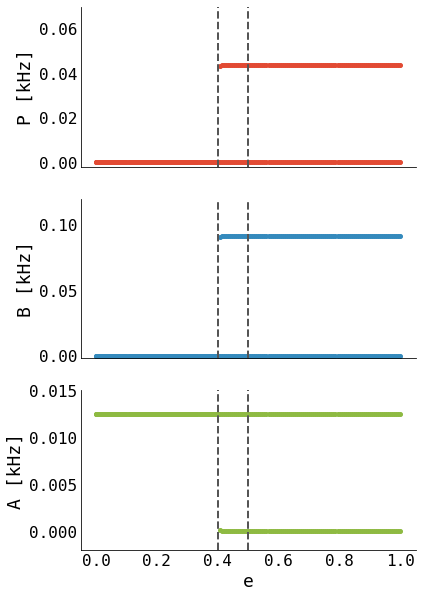

In [40]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(6, 10), sharex=True)
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for i, var in enumerate(bif_wrt_e["node"]):
    axs[i].plot(
        es, bif_wrt_e.sel({"node": var}).values, "o", color=colors[i], markersize=4
    )
    axs[i].set_ylim([-0.002, maxs[i]])
    axs[i].set_ylabel(f"{var.values} [kHz]")
    axs[i].axvline(0.4, linestyle="--", color="#555555")
    axs[i].axvline(0.5, linestyle="--", color="#555555")
    sns.despine(ax=axs[i])
axs[-1].set_xlabel("e")
plt.savefig("../figs/bifurcation_wrt_e.pdf", transparent=True, bbox_inches="tight")